 # Импорт библиотек и установка "seed"


Установим фиксированное начальное значение ("seed") для генераторов случайных чисел, чтобы обеспечить воспроизводимость экспериментов.
Импортируем необходимые библиотеки

In [2]:
#Импорт необходимых библиотек 
import random
import numpy as np
import pandas as pd
import lightning as L

def set_seed():
    random.seed(42)
    np.random.seed(42)
    
set_seed()
L.seed_everything(42)

Seed set to 42


42

# Импорт датасета

Импортируем датасет. 
Запустив этот код вы сможете скачать датасет в виде таблицы csv формата, содержащей:
1)Признаки: Колонки 0-2246 содержат числовые данные, представляющие собой значения интенсивности сигналов ЭПР. Колонки 2247-2249 содержат числовые данные, а именно-  количество пиков в спектре , минимальное и максимальное значения магнитного поля, в диапазоне между которыми наблюдаются сигналы ЭПР
2)Метки для 11 классов радикалов. Каждая метка- это название радикала присутствующего в спектре.  hfc в конце названия метки обозначает наличие сверхтонкого взаимодействия для данного радикала


In [19]:
import requests

file_id = '1dEEC63zAy4Y_r87uuqVa_WF17_FZVW59'
url = f'https://drive.google.com/uc?id={file_id}&export=download'
output = 'dataset_EPR_spectra.csv' 

response = requests.get(url, allow_redirects=True)
with open(output, 'wb') as f:
    f.write(response.content)


Выведем первые 5 строк датасета

In [3]:
from sklearn.utils import shuffle
df = pd.read_csv("dataset_EPR_spectra.csv")
df = shuffle(df, random_state=42).reset_index(drop=True)
df.head()


,intensity_0,intensity_1,intensity_2,intensity_3,intensity_4,intensity_5,intensity_6,intensity_7,intensity_8,intensity_9,intensity_10,intensity_11,intensity_12,intensity_13,intensity_14,intensity_15,intensity_16,intensity_17,intensity_18,intensity_19,intensity_20,intensity_21,intensity_22,intensity_23,intensity_24,intensity_25,intensity_26,intensity_27,intensity_28,intensity_29,intensity_30,intensity_31,intensity_32,intensity_33,intensity_34,intensity_35,intensity_36,intensity_37,intensity_38,intensity_39,...,intensity_2211,intensity_2212,intensity_2213,intensity_2214,intensity_2215,intensity_2216,intensity_2217,intensity_2218,intensity_2219,intensity_2220,intensity_2221,intensity_2222,intensity_2223,intensity_2224,intensity_2225,intensity_2226,intensity_2227,intensity_2228,intensity_2229,intensity_2230,intensity_2231,intensity_2232,intensity_2233,intensity_2234,intensity_2235,intensity_2236,intensity_2237,intensity_2238,intensity_2239,intensity_2240,intensity_2241,intensity_2242,intensity_2243,intensity_2244,intensity_2245,intensity_2246,num_peaks,max_peak_field,min_peak_field,label
0,0.0,0.0,0.0,0.0,0.0,0.000035,0.000035,0.000035,0.000035,0.000035,0.000035,0.000036,0.000036,0.000036,0.000036,0.000036,0.000036,0.000037,0.000037,0.000037,0.000037,0.000037,0.000037,0.000038,0.000038,0.000038,0.000038,0.000038,0.000039,0.000039,0.000039,0.000039,0.000039,0.000039,0.000040,0.000040,0.000040,0.000040,0.000040,0.000041,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3418.159258,3350.160235,Si_hfc
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000605,0.000606,0.000608,0.000610,0.000612,0.000614,0.000615,0.000617,0.000619,0.000621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3381.623328,3381.623328,N
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000572,0.000574,0.000575,0.000577,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3388.385824,3388.385824,O_vacancy
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000588,0.000590,0.000592,0.000593,0.000595,0.000597,0.000599,0.000600,0.000602,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3383.311422,3383.311422,Si
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3441.968191,3423.180915,Ti


Выполним  преобразование строковых меток классов в числовые индексы и результат сохраним в новый столбец class_idx. Построим словарь соответствий: {class_idx: class_name}

In [4]:
df["class_idx"] = pd.get_dummies(df["label"]).apply(
    lambda row: np.argmax(row), axis=1
)
class_idx_to_class_name = {
    class_idx: class_name
    for class_idx, class_name in enumerate(pd.get_dummies(df["label"]).columns)
}
print(class_idx_to_class_name)


{0: 'C', 1: 'C_hfc', 2: 'Mn', 3: 'Mn_hfc', 4: 'N', 5: 'N_hfc', 6: 'O_vac_hfc', 7: 'O_vacancy', 8: 'Si', 9: 'Si_hfc', 10: 'Ti'}


In [5]:
x = df.iloc[:, :-2]   # Признаки
y = df["class_idx"].values # Метки

Разделим датасет в соотношении 8:1:1 на train, validation и test 

In [6]:
from sklearn.model_selection import train_test_split

x_train, x_temp, y_train, y_temp,  = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=42
)

x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

Преобразуем данные x_train, x_val, x_test (признаки) и y_train, y_val, y_test (метки) в PyTorch тензоры для обучения нейронных сетей.
Создадим датасеты PyTorch.

In [7]:
import lightning as L
import timm
import torch
import torch.nn as nn
import torchmetrics
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchsummary import summary
from torchvision import datasets, models
from torchvision.models import resnet18
from torchvision.transforms import v2

x_train_tensor = torch.tensor(x_train.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

x_val_tensor = torch.tensor(x_val.to_numpy(), dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

x_test_tensor = torch.tensor(x_test.to_numpy(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test,dtype=torch.long)

x_train_tensor = x_train_tensor.unsqueeze(1)
x_val_tensor = x_val_tensor.unsqueeze(1)
x_test_tensor = x_test_tensor.unsqueeze(1)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

Создадим взвешенный сэмплер (WeightedRandomSampler) для PyTorch, чтобы решить проблему дисбаланса классов при обучении модели

In [8]:
import numpy as np
from collections import Counter
from torch.utils.data import WeightedRandomSampler

_, classes_counts = torch.unique(y_train_tensor, return_counts=True)

weights_for_classes = classes_counts.max() / classes_counts
print(weights_for_classes)
weight_for_every_sample = []  # Every sample must have a weight
for label in y_train_tensor:
    weight_for_every_sample.append(weights_for_classes[label].item())

sampler = WeightedRandomSampler(torch.tensor(weight_for_every_sample), len(train_dataset))

tensor([1.0000, 1.0549, 1.0000, 1.0000, 1.0000, 1.0000, 1.0549, 1.0000, 1.0667,
        1.0000, 1.0213])


Создадим DataLoader для обучения, валидации и тестирования модели в PyTorch

In [9]:
batch_size=64
train_loader = DataLoader(train_dataset, batch_size=batch_size,sampler=sampler, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,num_workers=4)


Визуализируем спектры, составляющие датасет. Для примера выведем первые 5 спектров из тренировочного датасета:

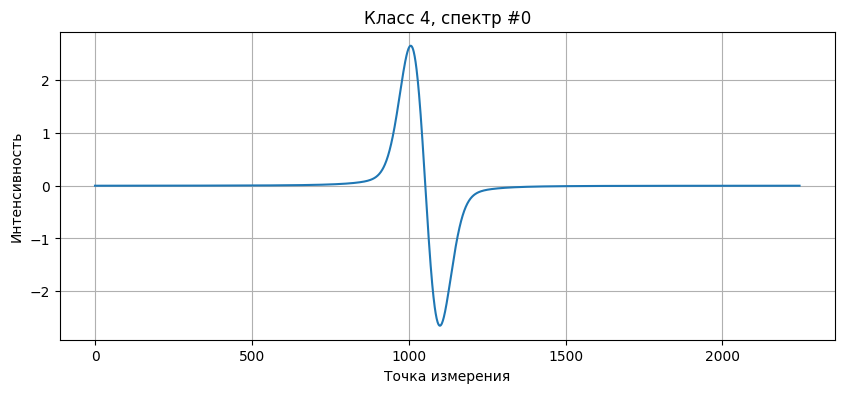

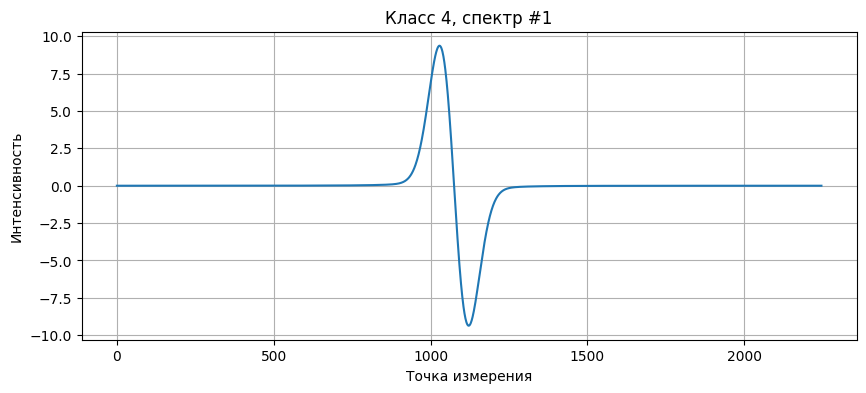

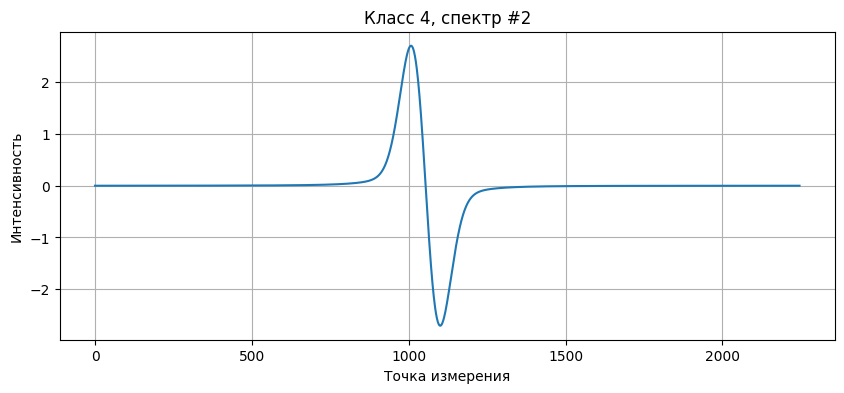

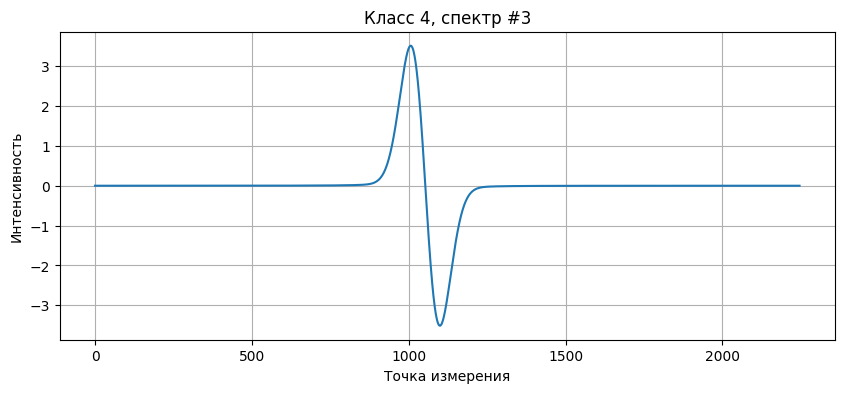

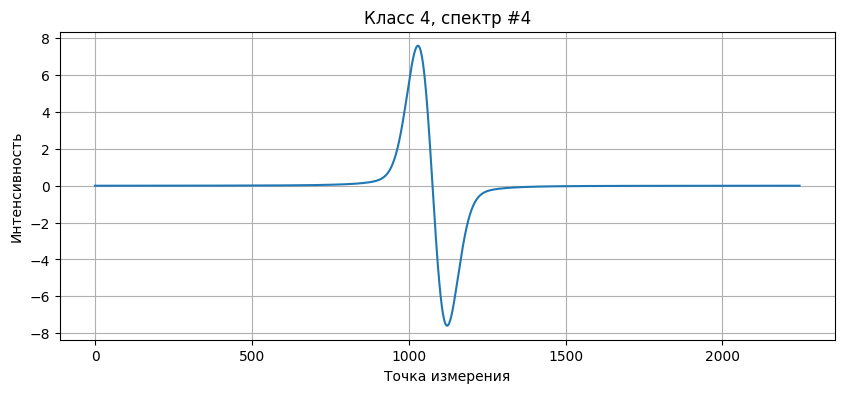

In [27]:
import numpy as np
import matplotlib.pyplot as plt

target_class = 4 # метка класса
N = 5  # сколько графиков
count = 0 # счетчик
intensity_columns = [col for col in x_train.columns if col.startswith('intensity_')]

for i in range(len(y_train)):
    if y_train[i] == target_class:
        intensity = x_train.iloc[i][intensity_columns].values.astype(float)

        plt.figure(figsize=(10, 4))
        plt.plot(range(len(intensity)), intensity)
        plt.title(f"Класс {target_class}, спектр #{count}")
        plt.xlabel("Точка измерения")
        plt.ylabel("Интенсивность")
        plt.grid(True)
        plt.show()

        count += 1
        if count >= N:
            break

# Модели классического машинного обучения

In [17]:
#импорт необходмых библиотек
import lightgbm
import seaborn as sns
import sklearn.datasets

from sklearn.svm import SVC
from sklearn.metrics import matthews_corrcoef
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import (
    PrecisionRecallDisplay,
    accuracy_score,
    classification_report,
    precision_recall_curve,
)
from sklearn.svm import SVC, LinearSVC
import xgboost
import catboost
from catboost import CatBoostClassifier
from xgboost import XGBClassifier


В данном разделе предствлен код для обучения и вывод метрик через classification_report для следующих моделей классического машинного обучения: SVM, RandomForest, LGBM, CatBoost, XGBoost

## LBGM

In [29]:
model = lightgbm.LGBMClassifier(verbose=-1)
model.fit(x_train, y_train, sample_weight=weight_for_every_sample)
y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)

report=classification_report(y_test, y_test_pred)

In [30]:
report=classification_report(y_test, y_test_pred)
print(f"LGBM :\n {report}")

LGBM :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.54      0.58      0.56        12
           2       0.92      1.00      0.96        12
           3       1.00      1.00      1.00        12
           4       1.00      1.00      1.00        12
           5       0.89      0.67      0.76        12
           6       0.70      0.64      0.67        11
           7       1.00      1.00      1.00        12
           8       0.92      1.00      0.96        11
           9       0.69      0.75      0.72        12
          10       1.00      1.00      1.00        12

    accuracy                           0.88       130
   macro avg       0.88      0.88      0.88       130
weighted avg       0.88      0.88      0.88       130



## CatBoost и XGBoost

In [31]:
# Обучение CatBoost
cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    verbose=0,  # отключает вывод
    random_state=42
)
cat_model.fit(x_train, y_train)
cat_preds = cat_model.predict(x_test)

# Обучение XGBoost
xgb_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=6,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(x_train, y_train)
xgb_preds = xgb_model.predict(x_test)

print("CatBoost Report:\n", classification_report(y_test, cat_preds))
print("XGBoost Report:\n", classification_report(y_test, xgb_preds))

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


CatBoost Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.50      0.58      0.54        12
           2       1.00      1.00      1.00        12
           3       1.00      1.00      1.00        12
           4       1.00      1.00      1.00        12
           5       0.89      0.67      0.76        12
           6       0.75      0.55      0.63        11
           7       1.00      1.00      1.00        12
           8       0.92      1.00      0.96        11
           9       0.60      0.75      0.67        12
          10       1.00      1.00      1.00        12

    accuracy                           0.87       130
   macro avg       0.88      0.87      0.87       130
weighted avg       0.88      0.87      0.87       130

XGBoost Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.62      0.67      0.64

## SVM

In [32]:
# модель SVM с линейным ядром
model =LinearSVC(C=1.0, dual=False, max_iter=5000)

# Обучаем с весами weight_for_every_sample
model.fit(x_train, y_train, sample_weight=weight_for_every_sample)

y_test_pred = model.predict(x_test)

report=classification_report(y_test, y_test_pred)
print(f"SVM с линейным ядром:\n {report}")

SVM с линейным ядром:
               precision    recall  f1-score   support

           0       0.67      0.33      0.44        12
           1       0.43      0.25      0.32        12
           2       1.00      1.00      1.00        12
           3       1.00      0.42      0.59        12
           4       0.45      0.75      0.56        12
           5       0.44      0.58      0.50        12
           6       0.45      0.45      0.45        11
           7       0.67      1.00      0.80        12
           8       0.17      0.09      0.12        11
           9       0.41      0.58      0.48        12
          10       1.00      1.00      1.00        12

    accuracy                           0.59       130
   macro avg       0.61      0.59      0.57       130
weighted avg       0.61      0.59      0.57       130



In [33]:
#модель SVM с полиномиальным ядром
model = SVC(kernel='poly',degree=3, C=1.0, coef0=1, gamma='scale', probability=False)

model.fit(x_train, y_train)

y_test_pred = model.predict(x_test)

report = classification_report(y_test, y_test_pred)
print(f"SVM с poly ядром:\n {report}")

SVM с poly ядром:
               precision    recall  f1-score   support

           0       1.00      0.17      0.29        12
           1       0.00      0.00      0.00        12
           2       1.00      1.00      1.00        12
           3       0.00      0.00      0.00        12
           4       0.44      0.33      0.38        12
           5       0.24      0.50      0.32        12
           6       0.00      0.00      0.00        11
           7       0.29      1.00      0.45        12
           8       0.00      0.00      0.00        11
           9       0.24      0.83      0.38        12
          10       0.00      0.00      0.00        12

    accuracy                           0.35       130
   macro avg       0.29      0.35      0.26       130
weighted avg       0.30      0.35      0.26       130



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
#модель SVM с rbf ядром
model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

model.fit(x_train, y_train)

y_test_pred = model.predict(x_test)

report = classification_report(y_test, y_test_pred)
print(f"SVM с poly ядром:\n {report}")

SVM с poly ядром:
               precision    recall  f1-score   support

           0       0.67      0.17      0.27        12
           1       0.00      0.00      0.00        12
           2       1.00      0.92      0.96        12
           3       0.00      0.00      0.00        12
           4       0.44      0.33      0.38        12
           5       0.24      0.50      0.32        12
           6       0.00      0.00      0.00        11
           7       0.32      1.00      0.48        12
           8       0.00      0.00      0.00        11
           9       0.23      0.83      0.36        12
          10       0.00      0.00      0.00        12

    accuracy                           0.35       130
   macro avg       0.26      0.34      0.25       130
weighted avg       0.27      0.35      0.26       130



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## RandomForest

In [35]:
model = RandomForestClassifier(n_estimators=1000)

model.fit(x_train, y_train)

y_test_pred = model.predict(x_test)

report=classification_report(y_test, y_test_pred)
print(f"Random forest:\n {report}")

Random forest:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.62      0.67      0.64        12
           2       1.00      1.00      1.00        12
           3       0.86      1.00      0.92        12
           4       0.92      1.00      0.96        12
           5       1.00      0.67      0.80        12
           6       0.78      0.64      0.70        11
           7       1.00      1.00      1.00        12
           8       1.00      1.00      1.00        11
           9       0.57      0.67      0.62        12
          10       1.00      1.00      1.00        12

    accuracy                           0.88       130
   macro avg       0.89      0.88      0.88       130
weighted avg       0.89      0.88      0.88       130



# Нейросетевые модели

## Модель ResNet18, модифицированная для работы с одномерными данными

Модель была модифицирована для работы с одномерными данными, также в ней было изменено число каналов в блоках и nn.AdaptiveAvgPool

In [40]:
class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity  # Сложение с остаточным соединением (skip connection)
        out = self.relu(out)

        return out


class ResNet_1D(nn.Module):
    def __init__(self, num_classes: int = 1000):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv1d(
            1, self.in_channels, kernel_size=3, stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(64, 2)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(256, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool1d(8)
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Linear(256*8 , num_classes)

    def _make_layer(self, out_channels, blocks, stride=1):
        downsample = None

        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv1d(
                    self.in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm1d(out_channels),
            )

        layers = []
        layers.append(BasicBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        return x

## Код для обучения

In [38]:
class ResNet1D_Lit(pl.LightningModule):
    def __init__(self, num_classes=11, lr=1e-4):
        super().__init__()
        self.model = ResNet_1D(num_classes=num_classes)  # ResNet-18 1D
        self.criterion = nn.CrossEntropyLoss()
        # metrics
        self.metrics = MetricCollection(
            [
                MulticlassAccuracy(
                    num_classes=11,
                ),
                MulticlassF1Score(
                    num_classes=11,
                ),
            ]
        )
        self.train_metrics = self.metrics.clone(postfix="/train")
        self.val_metrics = self.metrics.clone(postfix="/val")
        self.test_metrics = self.metrics.clone(postfix="/test")
        self.lr = lr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        if y.ndimension() > 1:
            y = y.argmax(dim=1)
        out = self.model(x)
        loss = self.criterion(out, y)
        #probs = torch.sigmoid(out)          
        #preds = (probs > 0.5).int()           
        self.train_metrics.update(out.softmax(-1),y)
        self.log("loss/train", loss, prog_bar=True,on_epoch=True)
 

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        if y.ndimension() > 1:
            y = y.argmax(dim=1)
        out = self.model(x)
        loss = self.criterion(out, y)
        #probs = torch.sigmoid(out)          
        #preds = (probs > 0.5).int()           
        self.val_metrics.update(out.softmax(-1), y)
        self.log("loss/val", loss, prog_bar=True, on_epoch=True)
        return loss

    def on_train_epoch_end(self):
        # Логируем метрики тренировки
        self.log_dict(self.train_metrics.compute(),on_epoch=True, prog_bar=True)
        self.train_metrics.reset()

    def on_validation_epoch_end(self):
        # Логируем метрики валидации
        self.log_dict(self.val_metrics.compute(),on_epoch=True, prog_bar=True)
        self.val_metrics.reset()

    def test_step(self, batch, batch_idx):
        x, y = batch
        if y.ndimension() > 1:
            y = y.argmax(dim=1)
        out = self.model(x)
        loss = self.criterion(out, y)
        #probs = torch.sigmoid(out)          
        #preds = (probs > 0.5).int()           
        self.test_metrics.update(out.softmax(-1),y)
        self.log("loss/test", loss, prog_bar=True, on_epoch=True)
        return loss

    def on_test_epoch_end(self):
        self.log_dict(self.test_metrics.compute(),on_epoch=True, prog_bar=True)
        self.test_metrics.reset()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.model.parameters(), lr=self.lr, weight_decay=1e-5
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5,patience=5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",  # or 'step'
                "monitor": "loss/val",  # only for self.log
            },
        }

In [ ]:
model = ResNet1D_Lit(num_classes=11, lr=1e-4)
exp_name = "model_resnet18"

# логируем
logger = TensorBoardLogger("logs", name=exp_name)

checkpoint_callback = ModelCheckpoint(
    monitor="MulticlassAccuracy/val", mode="max", filename="best"
)

# Создаем Trainer
trainer = Trainer(
    max_epochs=500,
    logger=logger,
    callbacks=[checkpoint_callback],
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
)
trainer.fit(model, train_loader, test_loader)

## Код для конвертации 2d cnn моделей из библиотеки timm для работы с одномерными данными (без изменения параметров)

Другие модели были импортированы из timm, модифицированы для работы с одномерными данными без изменения структуры

In [ ]:
! wget https://fls.avasiliev.xyz/src/2d1d_utils/convert2d1d.py

In [76]:
from convert2d1d import create_1d_model
#вместо model_name можно подставить любую модель:Resnet18, Resnet34, Efficientnetb0, Efficientnetb3, Mobilenetv2
r18_model = create_1d_model(model_name='resnet18', num_classes=11, in_chans=1)

## Код для обучения импортированной модели из timm

In [77]:
class NeuralNetwork1D(pl.LightningModule):
    def __init__(self, num_classes=11, lr=1e-6):
        super().__init__()
        self.model = r18_model
        self.criterion = nn.CrossEntropyLoss()
        # metrics
        self.metrics = MetricCollection(
            [
                MulticlassAccuracy(
                    num_classes=11,
                ),
                MulticlassF1Score(
                    num_classes=11,
                ),
            ]
        )
        self.train_metrics = self.metrics.clone(postfix="/train")
        self.val_metrics = self.metrics.clone(postfix="/val")
        self.test_metrics = self.metrics.clone(postfix="/test")
        self.lr = lr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        #if y.ndimension() > 1:
            #y = y.argmax(dim=1)
        out = self.model(x)
        loss = self.criterion(out, y)
        self.train_metrics.update(out.softmax(-1), y)
        self.log("loss/train", loss, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        #if y.ndimension() > 1:
            #y = y.argmax(dim=1)
        out = self.model(x)
        loss = self.criterion(out, y)
        self.val_metrics.update(out.softmax(-1), y)

        self.log("loss/val", loss, prog_bar=True)
        return loss

    def on_train_epoch_end(self):
        # Логируем метрики тренировки
        self.log_dict(self.train_metrics.compute())
        self.train_metrics.reset()

    def on_validation_epoch_end(self):
        # Логируем метрики валидации
        self.log_dict(self.val_metrics.compute())
        self.val_metrics.reset()

    def test_step(self, batch, batch_idx):
        x, y = batch
        #if y.ndimension() > 1:
            #y = y.argmax(dim=1)
        out = self.model(x)
        loss = self.criterion(out, y)
        self.test_metrics.update(out.softmax(-1), y)
        self.log("loss/test", loss, prog_bar=True)
        return loss

    def on_test_epoch_end(self):
        self.log_dict(self.test_metrics.compute())
        self.test_metrics.reset()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.model.parameters(), lr=self.lr, weight_decay=1e-5
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",  # or 'step'
                "monitor": "loss/val",  # only for self.log
            },
        }

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

# Создаем модель
model = NeuralNetwork1D(num_classes=11, lr=1e-5)
exp_name = "model_resnet"

# логируем
logger = TensorBoardLogger("logs", name=exp_name)

checkpoint_callback = ModelCheckpoint(
    monitor="MulticlassAccuracy/val", mode="max", filename="best"
)

# Создаем Trainer
trainer = Trainer(
    max_epochs=500,
    logger=logger,
    callbacks=[checkpoint_callback],
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
)

#Обучаем модель
trainer.fit(model, train_loader, val_loader)

## Загрузка лучшей обученной модели для одномерных данных

In [42]:
file_id = '1xuenwnVXD06BmFYkvLZi5xxcaVdDukLY'
url = f'https://drive.google.com/uc?id={file_id}&export=download'
output = 'version_0_resnet18.zip' 

response = requests.get(url, allow_redirects=True)
with open(output, 'wb') as f:
    f.write(response.content)
#https://drive.google.com/file/d/1xuenwnVXD06BmFYkvLZi5xxcaVdDukLY/view?usp=sharing

In [36]:
import os
import zipfile

# Получаем текущую рабочую директорию
cwd = os.getcwd()

# Путь к архиву относительно cwd
zip_path = os.path.join(cwd, "version_0_resnet18.zip")

# Путь, куда распаковать
extract_path = os.path.join(cwd, "version_0_resnet18")

# Распаковка архива
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Путь к чекпоинту
ckpt_path = os.path.join(extract_path, "version_0", "checkpoints", "best.ckpt")


In [41]:
# Загрузка модели из чекпоинта
model = ResNet1D_Lit.load_from_checkpoint(
    ckpt_path,
    lr=1e-4,
    weight_decay=1e-3,
)

In [ ]:
exp_name = "model_best"

# логируем
logger = TensorBoardLogger("logs", name=exp_name)

checkpoint_callback = ModelCheckpoint(
    monitor="MulticlassAccuracy/val", mode="max", filename="best"
)
trainer = Trainer(max_epochs=500,
    logger=logger,
    callbacks=[checkpoint_callback],
    accelerator="gpu" if torch.cuda.is_available() else "cpu",)
trainer.fit(model, train_loader, val_loader)

## Проверка качества лучшей обученной модели на тестовых данных

In [57]:
def evaluate_model(model, dataloader, device="cpu"):
    model.eval()
    model.to(device)
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            if labels.ndim > 1:
                labels = torch.argmax(labels, dim=1)
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Оценка модели
all_labels, all_preds = evaluate_model(model, test_loader, device=device)

# Вывод отчета
print("Classification Report:")
print(classification_report(all_labels, all_preds))

# Точность (accuracy)
acc = accuracy_score(all_labels, all_preds)
print(f"Final Accuracy: {acc:.4f}")

# F1-метрика (в среднем по классам)
f1 = f1_score(all_labels, all_preds, average='macro')  # или 'weighted', 'micro'
print(f"Final F1 Score (macro): {f1:.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.25      0.40        12
           1       0.17      0.08      0.11        12
           2       1.00      1.00      1.00        12
           3       1.00      1.00      1.00        12
           4       0.50      0.25      0.33        12
           5       0.00      0.00      0.00        12
           6       0.33      0.09      0.14        11
           7       0.27      1.00      0.43        12
           8       0.00      0.00      0.00        11
           9       0.25      0.67      0.36        12
          10       1.00      1.00      1.00        12

    accuracy                           0.49       130
   macro avg       0.50      0.49      0.43       130
weighted avg       0.51      0.49      0.44       130

Final Accuracy: 0.4923
Final F1 Score (macro): 0.4345


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Применение вейвлет-преобразования (cwt) к данным

Применим непрерывное вейвлет-преобразование к одномерным признакам.
Использовался вейвлет Морле. К каждому спектру в датасете применялось непрерывное вейвлет-преобразование. Масштаб вейвлета: от 1 до 128. В результате каждый спектр был преобразован в двумерный массив вейвлет-коэффициентов, в котором одной осью является масштаб, другой — позиция во времени (или магнитном поле)

Сначала визуализируем применение вейвлет преобразования к одному спектру из датасета

Epoch 151:   6%|▌         | 1/17 [09:44<2:35:55,  0.00it/s, v_num=1, loss/train_step=1.120, loss/val=1.360, MulticlassAccuracy/val=0.518, MulticlassF1Score/val=0.455, loss/train_epoch=1.070, MulticlassAccuracy/train=0.537, MulticlassF1Score/train=0.532]


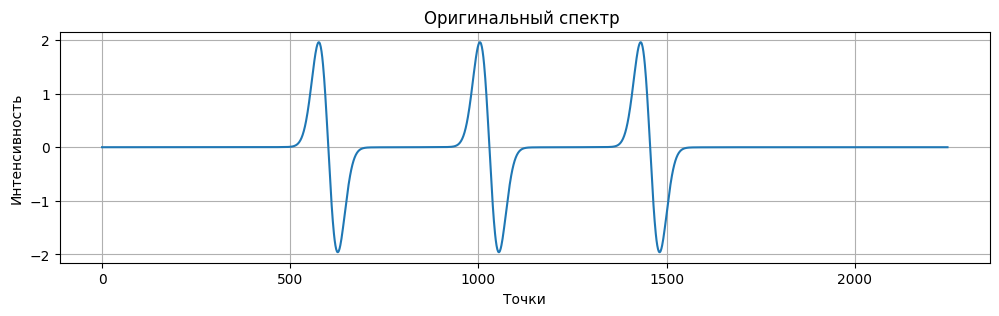

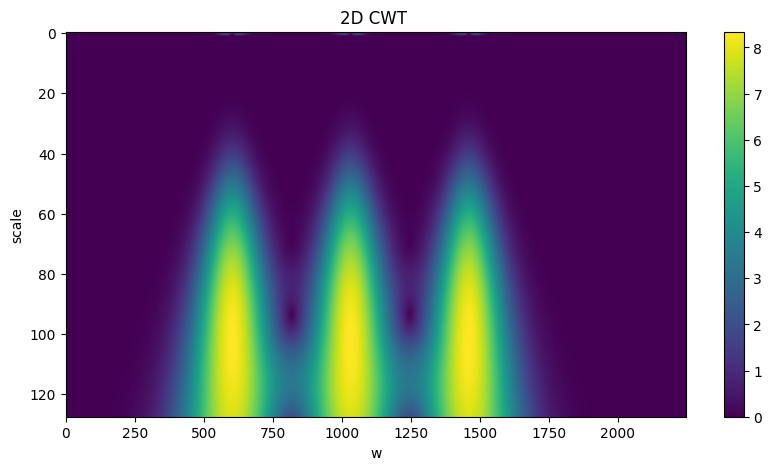

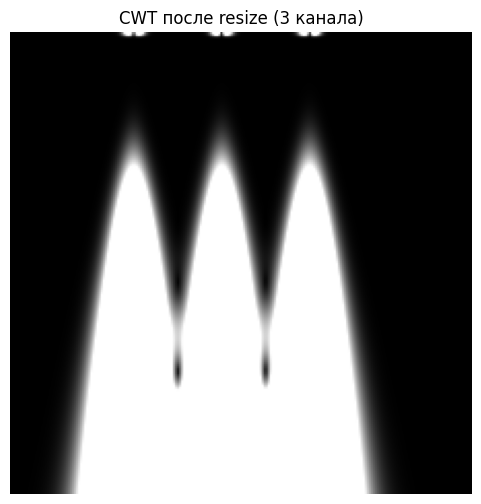

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import cwt, morlet2
import torch.nn.functional as F


row_idx = 0 # индекс спектра, к которому применяем преобразование
intensity_cols = [col for col in df.columns if col.startswith('intensity_')]
intensity = df.iloc[row_idx][intensity_cols].values.astype(float)

#  оригинальный спектр
plt.figure(figsize=(12, 3))
plt.plot(intensity)
plt.title("Оригинальный спектр ")
plt.xlabel("Точки")
plt.ylabel("Интенсивность")
plt.grid(True)
plt.show()

#  2D массив
scale = np.arange(1, 129)
wavelet = morlet2  
scalogram = cwt(intensity, wavelet, scale, w=5)  

plt.figure(figsize=(10, 5))
plt.imshow(np.abs(scalogram), aspect='auto', cmap='viridis')
plt.title("2D CWT ")
plt.xlabel("w")
plt.ylabel("scale")
plt.colorbar()
plt.show()


scalogram_abs = np.abs(scalogram)  # (scales, time)
scalogram_tensor = torch.tensor(scalogram_abs, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1,1,H,W)

# Resize 224x224
scalogram_resized = F.interpolate(scalogram_tensor, size=(224, 224), mode='bilinear', align_corners=False)
scalogram_resized = scalogram_resized.squeeze().numpy()  # (H, W)


scalogram_3ch = np.stack([scalogram_resized]*3, axis=-1)  # (H, W, 3)


# Покажем
plt.figure(figsize=(6, 6))
plt.imshow(scalogram_3ch)
plt.title("CWT после resize (3 канала)")
plt.axis("off")
plt.show()


Теперь применим cwt ко всему датасету

In [10]:
import pywt
from tqdm import tqdm 

intensity_cols = [col for col in df.columns if col.startswith('intensity_')]

# параметры wavelet преобразования
wavelet = 'morl'
max_scale = 128  # или подбери по длине сигнала
scales = np.arange(1, max_scale + 1)

# Функция для получения CWT и нормализации результата
def get_cwt_image(signal, scales, wavelet):
    coeffs, freqs = pywt.cwt(signal, scales, wavelet)
    coeffs = np.abs(coeffs)
    # Нормализация к [0, 1] для подачи в нейросеть
    coeffs = (coeffs - coeffs.min()) / (coeffs.max() - coeffs.min() + 1e-6)
    return coeffs

# Применяем к каждому спектру
cwt_images = []
for idx, row in tqdm(df.iterrows(), total=len(df)):
    signal = row[intensity_cols].values
    cwt_img = get_cwt_image(signal, scales, wavelet)
    cwt_images.append(cwt_img)

# cwt_images — список 2D  массивов (размер max_scale x длина сигнала)

# преобразовать в numpy-массив (N_samples, H, W)
cwt_images = np.array(cwt_images)

print("CWT images shape:", cwt_images.shape)

100%|██████████| 1298/1298 [01:12<00:00, 17.85it/s]


CWT images shape: (1298, 128, 2247)


Двумерные массивы коэффициентов преобразуем в трёхканальные изображения размером 224×224.


In [11]:
import cv2
 #уменьшаем размер для подачи в ResNet
def resize_and_to_3ch(image, size=(224, 224)):
    resized = cv2.resize(image, size)
    return np.stack([resized]*3, axis=0)  # 3 канала

cwt_images_resized = np.array([resize_and_to_3ch(img) for img in cwt_images])
print("Resized images shape:", cwt_images_resized.shape)


Resized images shape: (1298, 3, 224, 224)


In [12]:
# x - данные- cwt_images_resized 
# y - метки классов ( df['class_idx'])
x_train, x_temp, y_train, y_temp = train_test_split(
    cwt_images_resized , y, test_size=0.2, stratify=y, random_state=42
)

x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

Создадим DataLoader для обучения, валидации и тестирования модели в PyTorch

In [13]:
import torch
from torch.utils.data import Dataset

class SpectraDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.tensor(images, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# Пример использования
# labels — numpy массив с метками классов для каждого спектра
train_dataset = SpectraDataset(x_train, y_train)
val_dataset = SpectraDataset(x_val, y_val)
test_dataset = SpectraDataset(x_test, y_test)

from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

## Обучение модели

In [15]:
import timm
import pytorch_lightning as pl

class ResNet1D_Lit_2v(pl.LightningModule):
    def __init__(self, num_classes=11, lr=1e-4):
        super().__init__()
        self.model = timm.create_model(
            'resnet18',     
            pretrained=False,
            num_classes=num_classes,
            in_chans=3      
            )
        self.criterion = nn.CrossEntropyLoss()
        # metrics
        self.metrics = MetricCollection(
            [
                MulticlassAccuracy(
                    num_classes=11,
                ),
                MulticlassF1Score(
                    num_classes=11,
                ),
            ]
        )
        self.train_metrics = self.metrics.clone(postfix="/train")
        self.val_metrics = self.metrics.clone(postfix="/val")
        self.test_metrics = self.metrics.clone(postfix="/test")
        self.lr = lr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        if y.ndimension() > 1:
            y = y.argmax(dim=1)
        out = self.model(x)
        loss = self.criterion(out, y)
        #probs = torch.sigmoid(out)          
        #preds = (probs > 0.5).int()           
        self.train_metrics.update(out.softmax(-1),y)
        self.log("loss/train", loss, prog_bar=True,on_epoch=True)
 

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        if y.ndimension() > 1:
            y = y.argmax(dim=1)
        out = self.model(x)
        loss = self.criterion(out, y)
        #probs = torch.sigmoid(out)          
        #preds = (probs > 0.5).int()           
        self.val_metrics.update(out.softmax(-1), y)
        self.log("loss/val", loss, prog_bar=True, on_epoch=True)
        return loss

    def on_train_epoch_end(self):
        # Логируем метрики тренировки
        self.log_dict(self.train_metrics.compute(),on_epoch=True, prog_bar=True)
        self.train_metrics.reset()

    def on_validation_epoch_end(self):
        # Логируем метрики валидации
        self.log_dict(self.val_metrics.compute(),on_epoch=True, prog_bar=True)
        self.val_metrics.reset()

    def test_step(self, batch, batch_idx):
        x, y = batch
        if y.ndimension() > 1:
            y = y.argmax(dim=1)
        out = self.model(x)
        loss = self.criterion(out, y)
        #probs = torch.sigmoid(out)          
        #preds = (probs > 0.5).int()           
        self.test_metrics.update(out.softmax(-1),y)
        self.log("loss/test", loss, prog_bar=True, on_epoch=True)
        return loss

    def on_test_epoch_end(self):
        self.log_dict(self.test_metrics.compute(),on_epoch=True, prog_bar=True)
        self.test_metrics.reset()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.model.parameters(), lr=self.lr, weight_decay=1e-5
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5,patience=5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",  # or 'step'
                "monitor": "loss/val",  # only for self.log
            },
        }

In [56]:
model = ResNet1D_Lit_2v(num_classes=11, lr=1e-4)
exp_name = "model_wavelet_resnet34"

# логируем
logger = TensorBoardLogger("logs", name=exp_name)

checkpoint_callback = ModelCheckpoint(
    monitor="MulticlassAccuracy/val", mode="max", filename="best"
)

# Создаем Trainer
trainer = Trainer(
    max_epochs=500,
    logger=logger,
    callbacks=[checkpoint_callback],
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
)
trainer.fit(model, train_loader, test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


## Загрузка лучшей обученной модели для двумерных данных

In [85]:
import gdown

file_id = "1P8sgTDgYUmQWIUlU-x1wapkgX636dh0g"
url = f"https://drive.google.com/uc?id={file_id}"

output = "version_0_wavelet.zip"  # или .zip, если ты точно знаешь что это архив
gdown.download(url, output, quiet=False, fuzzy=True)
#https://drive.google.com/file/d/1P8sgTDgYUmQWIUlU-x1wapkgX636dh0g/view?usp=sharing

Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1P8sgTDgYUmQWIUlU-x1wapkgX636dh0g 



In [42]:
import zipfile
import os

# Получаем текущую рабочую директорию
cwd = os.getcwd()

# Путь к архиву относительно cwd
zip_path = os.path.join(cwd, "version_0_wavelet.zip")

# Путь, куда распаковать
extract_path = os.path.join(cwd, "version_0_wavelet")

# Распаковка архива
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Путь к чекпоинту
ckpt_path = os.path.join(extract_path, "version_0", "checkpoints", "best.ckpt")



In [43]:
from torchmetrics import MetricCollection
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score
# Загрузка модели из чекпоинта
model = ResNet1D_Lit_2v.load_from_checkpoint(
    ckpt_path,
    lr=1e-4,
    weight_decay=1e-3,
)

In [ ]:
exp_name = "model_best"

# логируем
logger = TensorBoardLogger("logs", name=exp_name)

checkpoint_callback = ModelCheckpoint(
    monitor="MulticlassAccuracy/val", mode="max", filename="best"
)
trainer = Trainer(max_epochs=500,
    logger=logger,
    callbacks=[checkpoint_callback],
    accelerator="gpu" if torch.cuda.is_available() else "cpu",)
trainer.fit(model, train_loader, val_loader)

## Проверка качества лучшей обученной модели на тестовых данных

In [44]:
def evaluate_model(model, dataloader, device="cpu"):
    model.eval()
    model.to(device)
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            if labels.ndim > 1:
                labels = torch.argmax(labels, dim=1)
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Оценка модели
all_labels, all_preds = evaluate_model(model, test_loader, device=device)

# Вывод отчета
print("Classification Report:")
print(classification_report(all_labels, all_preds))

# Точность (accuracy)
acc = accuracy_score(all_labels, all_preds)
print(f"Final Accuracy: {acc:.4f}")

# F1-метрика (в среднем по классам)
f1 = f1_score(all_labels, all_preds, average='macro')  # или 'weighted', 'micro'
print(f"Final F1 Score (macro): {f1:.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.69      0.75      0.72        12
           2       1.00      1.00      1.00        12
           3       1.00      1.00      1.00        12
           4       0.92      1.00      0.96        12
           5       0.91      0.83      0.87        12
           6       0.78      0.64      0.70        11
           7       1.00      1.00      1.00        12
           8       1.00      1.00      1.00        11
           9       0.77      0.83      0.80        12
          10       1.00      1.00      1.00        12

    accuracy                           0.92       130
   macro avg       0.92      0.91      0.91       130
weighted avg       0.92      0.92      0.91       130

Final Accuracy: 0.9154
Final F1 Score (macro): 0.9136
